In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
from models.t2m_trans import uniform, cosine_schedule
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoModelForSeq2SeqLM, T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer
from models.t2m_trans import cosine_schedule, uniform, top_k, gumbel_sample
from einops import rearrange, repeat
from tqdm import tqdm


from utils.motion_process import recover_from_ric, recover_from_rot

In [3]:
from utils.skeleton import Skeleton
from utils.paramUtil import *
import visualization.plot_3d_global as plot_3d

skeleton = Skeleton(offset=torch.from_numpy(t2m_raw_offsets), 
                    kinematic_tree=t2m_kinematic_chain,
                    device='cuda')
skeleton.set_offset(torch.from_numpy(t2m_raw_offsets))

In [4]:

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)

trans_encoder = trans.Text2Motion_Transformer(num_vq=512, 
                                embed_dim=1024, 
                                clip_dim=768, 
                                block_size=51, 
                                num_layers=15, 
                                n_head=16, 
                                drop_out_rate=0.1, 
                                fc_rate=4,
                                has_cross_attn=True)


print ('loading checkpoint from {}'.format('pretrained/VQVAE/net_last.pth'))
ckpt = torch.load('pretrained/VQVAE/net_last.pth', map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

if args.resume_trans is not None:
    print ('loading transformer checkpoint from {}'.format('output/GPT_MaskGit_classifierfree_predlength_15layers_t5_embedding2/net_best_fid.pth'))
    ckpt = torch.load('output/GPT_MaskGit_classifierfree_predlength_15layers_t5_embedding2/net_best_fid.pth', map_location='cpu')
    trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()



Num transformer block: 15
Using cross attention: True
loading checkpoint from pretrained/VQVAE/net_last.pth
loading transformer checkpoint from output/GPT_MaskGit_classifierfree_predlength_15layers_t5_embedding2/net_best_fid.pth


Text2Motion_Transformer(
  (tok_emb): Embedding(514, 1024)
  (cond_emb): Linear(in_features=768, out_features=1024, bias=True)
  (pos_embed): PositionEmbedding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (blocks): ModuleList(
    (0-14): 15 x ModuleList(
      (0): Attention(
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (norm): LayerNorm()
        (context_norm): Identity()
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): Attention(
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (norm): Laye

In [5]:
tokenizer = AutoTokenizer.from_pretrained("checkpoints/flan-t5-base", legacy=True)
model = T5ForConditionalGeneration.from_pretrained("checkpoints/flan-t5-base").to('cuda')


In [6]:
mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

In [38]:
# clip_text = ["a person jumps up and down."]
# clip_text = ["a person is in T pose"]
# clip_text = ["a man runs in a cycle"]
# clip_text = ["a man steps forward and does a handstand."]

# clip_text = ["a person slightly crouches down and walks forward then back, then around slowly."]
# clip_text = ["a person jogs in place, slowly at first, then increases speed. they then back up and squat down."]
clip_text = ["A man rises from the ground, walks in a circle and sits back down on the ground."]

# clip_text = ["a person is throwing a ball, catches it back and then throw it again and catch it again"]
# clip_text = ["a man is squatting while bringing an object to his face"]

input_ids = tokenizer(clip_text, return_tensors="pt",)
# print(input_ids)
# forward pass through encoder only
output = model.encoder(
    input_ids=input_ids["input_ids"].cuda(), 
    attention_mask=input_ids["attention_mask"].cuda(), 
    return_dict=True
)
# get the final hidden states
t5_embedding = output.last_hidden_state.detach()
t5_embedding_mask = torch.ones((t5_embedding.shape[0], t5_embedding.shape[1]), dtype=torch.bool, device=t5_embedding.device)

In [39]:
seq_len = 50
timesteps = 18

ids = torch.full((1, seq_len), net.vqvae.num_code, dtype = torch.long).cuda()
mask = torch.ones((1, seq_len), dtype = torch.bool).cuda()
text_mask = t5_embedding_mask

scores = None
starting_temperature = 0.9

for step in range(timesteps):
    # breakpoint()
    is_first_step = step == 0
    is_last_step = step == (timesteps - 1)

    steps_til_x0 = timesteps - (step + 1)

    if not is_first_step and (scores is not None):
        time = torch.full((1,), step / timesteps).cuda()
        num_tokens_mask = (seq_len * torch.cos(time * np.pi * 0.5)).round().long().clamp(min = 1).cuda()

        _, indices = scores.topk(num_tokens_mask.item(), dim = -1)
        # breakpoint()
        mask = torch.zeros((1, seq_len)).cuda().scatter(1, indices, 1).bool()

    ids = torch.where(mask, net.vqvae.num_code, ids)

    # logits = trans(ids, feat_clip_text, token_mask=None, text_mask=None)
    if args.cond_drop_prob == 0:
        length_logit, logits = trans_encoder(ids, t5_embedding, token_mask=None, text_mask=text_mask)
    else:
        length_logit, logits = trans_encoder.forward_with_cond_scale(ids, t5_embedding, token_mask=None, text_mask=text_mask)


    temperature = starting_temperature * (steps_til_x0 / timesteps)
    pred_ids = gumbel_sample(logits, temperature = temperature)
    # pred_ids = logits.argmax(dim=-1)

    ids = torch.where(mask, pred_ids, ids)

    if not is_last_step:
        probs = logits.softmax(dim = -1)
        scores = probs.gather(2, rearrange(pred_ids, '... -> ... 1'))
        scores = 1 - rearrange(scores, '... 1 -> ...')
        scores = torch.where(mask, scores, -1e4)

try:
    # first_end = torch.nonzero(ids_ == net.vqvae.num_code).view(-1)[0]
    first_end = torch.argmax(length_logit[0], dim=-1)
    first_end = torch.clamp(first_end, 4, 50)
except:
    first_end = -1

pred_pose = net.forward_decoder(ids[0:1,:])


In [40]:
# pred_pose = pred_pose.float()
pose_xyz = recover_from_ric(pred_pose.float()*std.float()+mean.float(), 22)
pose_xyz = pose_xyz.reshape(1, -1, 22, 3)
# pose_xyz = pose_xyz / 6.0


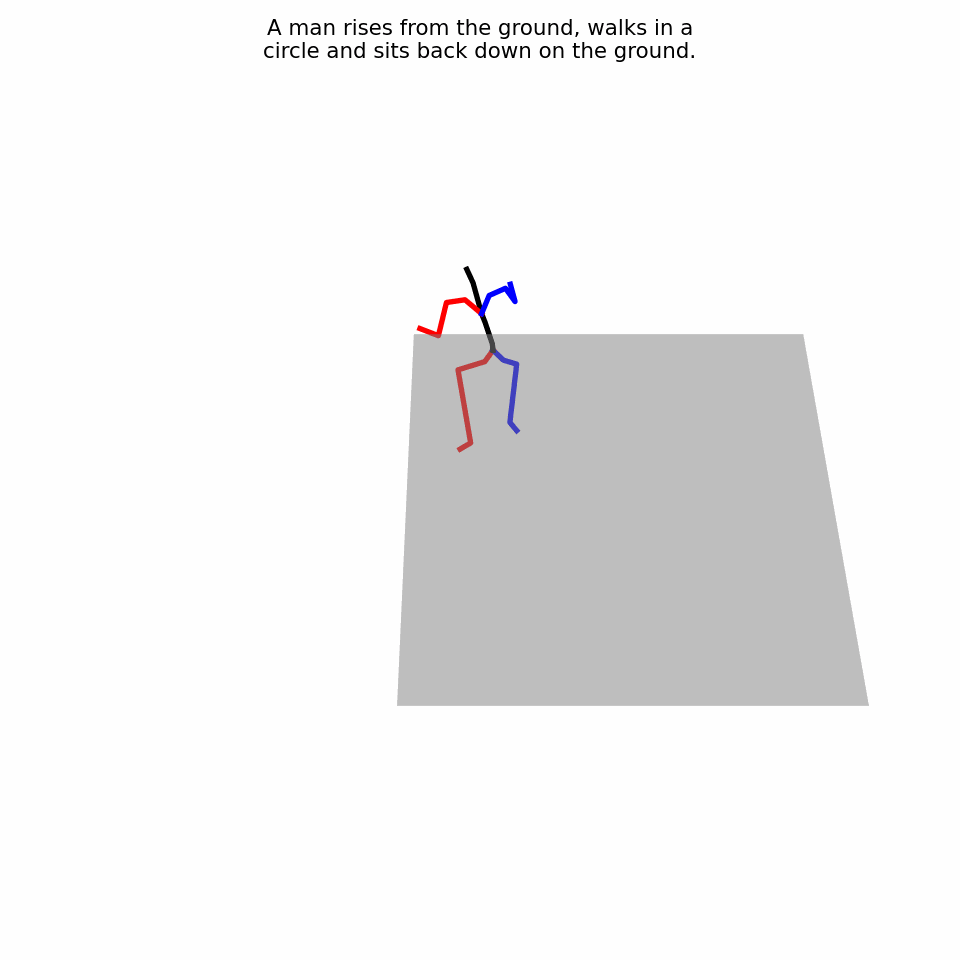

In [41]:
import visualization.plot_3d_global as plot_3d
from IPython.display import HTML
import base64


pose_vis = plot_3d.draw_to_batch(pose_xyz.detach().cpu().numpy(),clip_text, ['results/debug_predlength_t5/2.gif'])
b64 = base64.b64encode(open('results/debug_predlength_t5/2.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))